<a href="https://colab.research.google.com/github/Agudelo18/UDEA-ai4eng-20252---Pruebas-Saber-Pro-Colombia/blob/main/02_preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTAR LIBRERÍAS

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [27]:
os.environ['KAGGLE_CONFIG_DIR'] = "."

In [28]:
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
!unzip udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: submission_example.csv  
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


CARGAR LOS DATOS DE "train.csv"

In [30]:
z_train = pd.read_csv("train.csv")

In [31]:
# Configuración visual
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (10, 5)

In [32]:
print("\n===== INFORMACIÓN INICIAL DEL DATASET =====")
print(f" Dimensiones: {z_train.shape[0]} filas x {z_train.shape[1]} columnas")
print("\n Tipos de datos iniciales:")
print(z_train.dtypes.value_counts())
print("\n Valores faltantes por columna (top 10):")
print(z_train.isna().sum().sort_values(ascending=False).head(10))
print("==============================================")
display(z_train.head(3))


===== INFORMACIÓN INICIAL DEL DATASET =====
 Dimensiones: 692500 filas x 21 columnas

 Tipos de datos iniciales:
object     15
float64     4
int64       2
Name: count, dtype: int64

 Valores faltantes por columna (top 10):
F_TIENEAUTOMOVIL         43623
F_TIENELAVADORA          39773
F_TIENECOMPUTADOR        38103
F_ESTRATOVIVIENDA        32137
E_HORASSEMANATRABAJA     30857
F_TIENEINTERNET.1        26629
F_TIENEINTERNET          26629
F_EDUCACIONMADRE         23664
F_EDUCACIONPADRE         23178
E_PAGOMATRICULAPROPIO     6498
dtype: int64


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264


MAPEO DE VARIABLES ORDENADAS


 TOP 10 COLUMNAS CON VALORES FALTANTES (antes del preprocesamiento):


,Valores Faltantes
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498


<Figure size 1000x400 with 0 Axes>

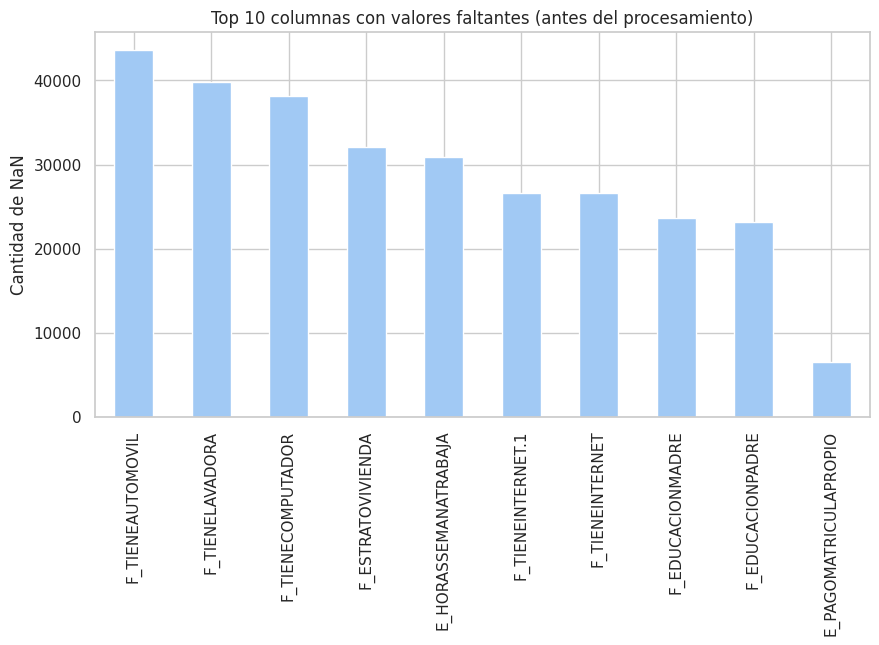

In [33]:

#ANÁLISIS DE VALORES FALTANTES ANTES

missing_before = z_train.isna().sum().sort_values(ascending=False)
missing_before_df = missing_before[missing_before > 0].to_frame(name="Valores Faltantes")

print("\n TOP 10 COLUMNAS CON VALORES FALTANTES (antes del preprocesamiento):")
display(missing_before_df.head(10))

# Gráfico de los valores faltantes
plt.figure(figsize=(10, 4))
missing_before_df.head(10).plot(kind="bar", legend=False)
plt.title("Top 10 columnas con valores faltantes (antes del procesamiento)")
plt.ylabel("Cantidad de NaN")
plt.show()

In [34]:
# Valor de matrícula (en millones estimados)
tuition_map = {
    "No pagó matrícula": 0.0,
    "Menos de 500 mil": 0.25,
    "Entre 500 mil y menos de 1 millón": 0.75,
    "Entre 1 millón y menos de 2.5 millones": 1.75,
    "Entre 2.5 millones y menos de 4 millones": 3.25,
    "Entre 4 millones y menos de 5.5 millones": 4.75,
    "Entre 5.5 millones y menos de 7 millones": 6.25,
    "Más de 7 millones": 7.5
}
z_train["E_VALORMATRICULAUNIVERSIDAD"] = z_train["E_VALORMATRICULAUNIVERSIDAD"].map(tuition_map)

# Estrato de vivienda
estrato_map = {
    "Estrato 1": 1,
    "Estrato 2": 2,
    "Estrato 3": 3,
    "Estrato 4": 4,
    "Estrato 5": 5,
    "Estrato 6": 6,
    "Sin Estrato": None
}
z_train["F_ESTRATOVIVIENDA"] = z_train["F_ESTRATOVIVIENDA"].map(estrato_map)

# Nivel educativo (padre/madre)
edu_map = {
    "No aplica": None,
    "No sabe": None,
    "Ninguno": 0,
    "Primaria incompleta": 1,
    "Primaria completa": 2,
    "Secundaria (Bachillerato) incompleta": 3,
    "Secundaria (Bachillerato) completa": 4,
    "Educación profesional incompleta": 5,
    "Educación profesional completa": 6,
    "Técnica o tecnológica incompleta": 7,
    "Técnica o tecnológica completa": 8,
    "Postgrado": 9
}
z_train["F_EDUCACIONPADRE"] = z_train["F_EDUCACIONPADRE"].map(edu_map)
z_train["F_EDUCACIONMADRE"] = z_train["F_EDUCACIONMADRE"].map(edu_map)


#VARIABLES BINARIAS (Sí/No)
bin_map = {"Si": 1, "No": 0}

for col in z_train.columns:
    if z_train[col].dtype == "object" and z_train[col].isin(["Si", "No"]).any():
        z_train[col] = z_train[col].map(bin_map)


#VARIABLE OBJETIVO
rendimiento_map = {"bajo": 0, "medio-bajo": 1, "medio-alto": 2, "alto": 3}
z_train["RENDIMIENTO_GLOBAL"] = z_train["RENDIMIENTO_GLOBAL"].map(rendimiento_map)

#SEPARAR VARIABLES INDEPENDIENTES Y OBJETIVO
X = z_train.drop(columns=["ID", "RENDIMIENTO_GLOBAL"], errors="ignore")
y = z_train["RENDIMIENTO_GLOBAL"]


#IDENTIFICAR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

print("\n=====  COLUMNAS DETECTADAS =====")
print(f"Numéricas: {len(numeric_cols)}")
print(f"Categóricas: {len(categorical_cols)}")





=====  COLUMNAS DETECTADAS =====
Numéricas: 15
Categóricas: 4


PIPELINE DE PREPROCESAMIENTO

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)
    ],
    remainder="passthrough"
)


SE APLICA EL PROCESAMIENTO

In [36]:
X_clean = preprocessor.fit_transform(X)
X_clean_df = pd.DataFrame(X_clean)

Unir X limpio con la variable objetivo

In [37]:
train_clean = pd.concat([X_clean_df, y.reset_index(drop=True)], axis=1)

INFORME PARA REVISION DESPUES DEL PROCESAMIENTO

In [38]:
print("\n=====  INFORMACIÓN DESPUÉS DEL PROCESAMIENTO =====")
print(f" Nuevas dimensiones: {train_clean.shape[0]} filas x {train_clean.shape[1]} columnas")
print(f" Valores faltantes totales: {train_clean.isna().sum().sum()}")
print("==============================================")


# Comparar tipos de datos
print("\n Cambios en tipos de datos:")
types_before = X.dtypes.value_counts().rename("Antes")
types_after = train_clean.dtypes.value_counts().rename("Después")
display(pd.concat([types_before, types_after], axis=1))


=====  INFORMACIÓN DESPUÉS DEL PROCESAMIENTO =====
 Nuevas dimensiones: 692500 filas x 2 columnas
 Valores faltantes totales: 0

 Cambios en tipos de datos:


,Antes,Después
float64,14,NaN
object,4,1.0
int64,1,1.0


/tmp/ipython-input-1527569547.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Antes", "Después"], y=[missing_before.sum(), missing_after], palette=["#E57373", "#81C784"])


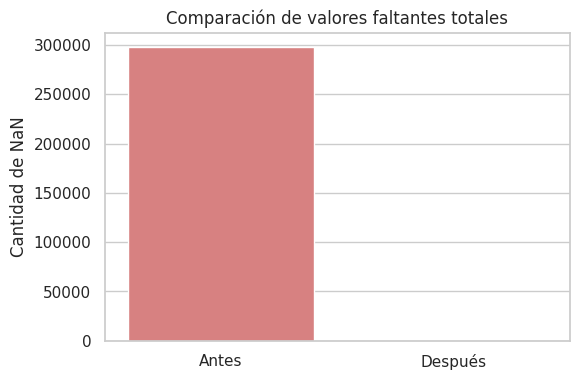

In [39]:

#COMPARAR VALORES FALTANTES ANTES Y DESPUÉS
missing_after = train_clean.isna().sum().sum()

plt.figure(figsize=(6, 4))
sns.barplot(x=["Antes", "Después"], y=[missing_before.sum(), missing_after], palette=["#E57373", "#81C784"])
plt.title("Comparación de valores faltantes totales")
plt.ylabel("Cantidad de NaN")
plt.show()

SE GUARDA EL RESULTADO

In [40]:
train_clean.to_csv("z_train_clean.csv", index=False)
print("Archivo guardado como: z_train_clean.csv")

Archivo guardado como: z_train_clean.csv
